In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tszip

In [2]:
data_dir = Path("../data")

In [3]:
# NOTE: The Pango labels in Viridian v04 are based on pangolin-data v1.21.
# For column info, see https://cov-lineages.org/resources/pangolin/output.html
pangolin_file = data_dir / "lineage_report.pangolin-data_v1.21.csv.gz"
pangolin_df = pd.read_csv(pangolin_file)
pangolin_df.head(1)

,taxon,lineage,conflict,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,scorpio_notes,version,pangolin_version,scorpio_version,constellation_version,is_designated,qc_status,qc_notes,note
0,n0,B,0.0,NaN,NaN,NaN,NaN,NaN,PANGO-v1.21,4.3.1,0.3.19,v0.1.12,True,pass,Ambiguous_content:0.02,Assigned from designation hash.


In [4]:
# All passing pangolin QC for assignment.
print(sum(pangolin_df["qc_status"] == "pass") / len(pangolin_df))

1.0


Conflicts: 17163/206897 (8.30)%


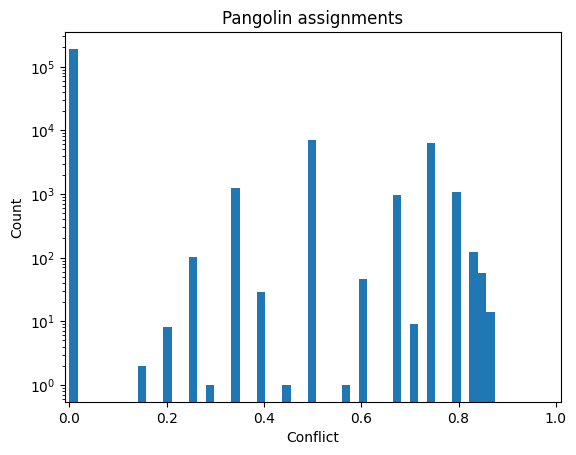

In [5]:
# "In the pangoLEARN model, a given sequence gets assigned to the most likely category
# based on known diversity. If a sequence can fit into more than one category, 
# the conflict score will be greater than 0 and reflect the number of categories 
# the sequence could fit into. If the conflict score is 0, this means that within 
# the current decision tree there is only one category that the sequence could be assigned to."
num_conflict = sum(pangolin_df["conflict"] > 0)
perc_conflict = num_conflict / len(pangolin_df) * 100
print(f"Conflicts: {num_conflict}/{len(pangolin_df)} ({perc_conflict:.2f})%")

plt.title("Pangolin assignments")
plt.ylabel("Count")
plt.xlabel("Conflict")
plt.xlim(-0.01, 1.01)
plt.hist(pangolin_df["conflict"], bins=50, log=True);

In [6]:
pangolin_df = pangolin_df[["taxon", "lineage"]]
pangolin_df.columns = ["taxon", "lineage_pd_v1.21"]

In [7]:
ts_file = data_dir / "v1-beta1_2023-02-21.pp.md.bpshift.ts.dated.il.tsz"
ts = tszip.decompress(ts_file)

In [8]:
imputed_pangos = []
for node in ts.nodes():
    if node.is_sample():
        continue
    imputed_pangos.append(
        {
            "taxon": "n" + str(node.id),
            "lineage_imputed": node.metadata["Imputed_Viridian_pangolin"],
        }
    )
imputed_df = pd.DataFrame(imputed_pangos)
imputed_df.head(1)

,taxon,lineage_imputed
0,n0,B


In [9]:
# Check that internal nodes align.
assert all(pangolin_df["taxon"] == imputed_df["taxon"])
merged_df = pangolin_df.merge(imputed_df, on="taxon")
len(merged_df)

206897

Count identical cases

In [10]:
num_identical = sum(merged_df["lineage_pd_v1.21"] == merged_df["lineage_imputed"])
perc_identical = num_identical / len(merged_df)
print(f"Identical: {num_identical}/{len(imputed_df)} ({perc_identical * 100:.2f}%)")

Identical: 186741/206897 (90.26%)


Examine discordant cases

In [11]:
is_discordant = merged_df["lineage_pd_v1.21"] != merged_df["lineage_imputed"]
discordant_df = merged_df[is_discordant].reset_index(drop=True)
discordant_df.head(1)

,taxon,lineage_pd_v1.21,lineage_imputed
0,n318,B.1.1.71,B.1.1


In [12]:
import json
import urllib.request
alias_key_url = "https://raw.githubusercontent.com/cov-lineages/pango-designation/refs/heads/master/pango_designation/alias_key.json"
with urllib.request.urlopen(alias_key_url) as url:
    alias_key = json.load(url)

In [13]:
lineage_notes_url = "https://raw.githubusercontent.com/cov-lineages/pango-designation/refs/heads/master/lineage_notes.txt"
lineage_notes = pd.read_csv(lineage_notes_url, sep="\t")
lineage_notes.head(1)

,Lineage,Description
0,A,One of the two original haplotypes of the pand...


In [14]:
withdrawn_lineages = [x[1:] for x in lineage_notes.Lineage if x.startswith('*')]
#withdrawn_lineages

In [15]:
# Some of the Pango labels in the discordant cases are withdrawn.
num_withdrawn_lineage_pd_v121 = sum(merged_df["lineage_pd_v1.21"].isin(withdrawn_lineages))
num_withdrawn_lineage_imputed = sum(merged_df["lineage_imputed"].isin(withdrawn_lineages))
print(f"Total: {len(merged_df)}")
print(f"Withdrawn (pangolin-assigned): {num_withdrawn_lineage_pd_v121}")
print(f"Withdrawn (sc2ts-imputed): {num_withdrawn_lineage_imputed}")

Total: 206897
Withdrawn (pangolin-assigned): 2
Withdrawn (sc2ts-imputed): 3


In [16]:
def _remap(x):
    if x.endswith("*"):
        x = x[:-1]
    split = x.split(".")
    alias = alias_key.get(split[0], "")
    if alias != "":
        x = ".".join([alias] + split[1:])
    return x


identical_decompressed = 0
sc2ts_unknown = 0   # unknown
sc2ts_r = [] # Unknown (R)
sc2ts_more_specific = []
pangolin_more_specific = []
other_cases = []

for i, row in merged_df.iterrows():
    if row["lineage_imputed"] == "Unknown":
        sc2ts_unknown += 1
        continue

    # Examine these case further.
    if row["lineage_imputed"] == "Unknown (R)":
        sc2ts_r.append(row["lineage_pd_v1.21"])
        continue

    # Decompress if not a Pango X.
    pango_v121_alias = row["lineage_pd_v1.21"]
    if row["lineage_pd_v1.21"].startswith("X"):
        pango_v121_decompressed = row["lineage_pd_v1.21"]
    else:
        pango_v121_decompressed = _remap(row["lineage_pd_v1.21"])

    pango_imputed_alias = row["lineage_imputed"]
    if row["lineage_imputed"].startswith("X"):
        pango_imputed_decompressed = row["lineage_imputed"]
    else:
        pango_imputed_decompressed = _remap(row["lineage_imputed"])

    # Great, nothing to do.
    if pango_v121_decompressed == pango_imputed_decompressed:
        identical_decompressed += 1
        continue

    # Examine these case further.
    if pango_imputed_decompressed.startswith(pango_v121_decompressed + "."):
        sc2ts_more_specific.append(
            (
                pango_v121_alias,
                pango_v121_decompressed,
                pango_imputed_alias,
                pango_imputed_decompressed,
            )
        )
    elif pango_v121_decompressed.startswith(pango_imputed_decompressed + "."):
        pangolin_more_specific.append(
            (
                pango_v121_alias,
                pango_v121_decompressed,
                pango_imputed_alias,
                pango_imputed_decompressed,
            )
        )
    else:
        other_cases.append(
            (
                pango_v121_alias,
                pango_v121_decompressed,
                pango_imputed_alias,
                pango_imputed_decompressed,
            )
        )

print(f"identical (decompressed): {identical_decompressed}")
print(f"sc2ts unknown: {sc2ts_unknown}")
print(f"sc2ts R: {len(sc2ts_r)}")
print(f"sc2ts-imputed more specific: {len(sc2ts_more_specific)}")
print(f"pangolin-assigned more specific: {len(pangolin_more_specific)}")
print(f"other: {len(other_cases)}")

identical (decompressed): 186741
sc2ts unknown: 43
sc2ts R: 929
sc2ts-imputed more specific: 18077
pangolin-assigned more specific: 627
other: 480


Examine recombinant nodes

In [17]:
# Most of the Pango X-associated nodes are not assigned to a Pango X by pangolin.
[x for x in sc2ts_r if x.startswith("X")]

['XM',
 'XF',
 'XM',
 'XL',
 'XQ',
 'XG',
 'XM',
 'XM',
 'XW',
 'XY',
 'XBG',
 'XBM',
 'XBB',
 'XBF',
 'XBB.1',
 'XBB.1.5.4']

Examine pangonet-based node distances of other cases

In [18]:
import nb_utils
rebar_dir = data_dir / ".." / "notebooks" / "dataset" / "rebar"
alias_key_file = rebar_dir / "alias_key.json"
lineage_notes_file = rebar_dir / "lineage_notes.txt"
pangonet = nb_utils.initialise_pangonet(alias_key_file, lineage_notes_file)

2025-04-01 08:12:29,882 INFO:Creating aliases.
2025-04-01 08:12:29,884 INFO:Creating network.


In [19]:
from collections import Counter


def compute_node_distances(cases):
    case_counts = Counter(cases)
    num_withdrawn = 0   # Count aliases, not decompressed labels
    num_pango_Xs = 0
    node_dist_discordant = np.zeros(len(case_counts), dtype=np.int32) - 1
    node_dist_table = []
    for i, labels in enumerate(case_counts):
        (
            pango_v121_alias,
            pango_v121_decompressed,
            pango_imputed_alias,
            pango_imputed_decompressed,
        ) = labels
        if (pango_v121_alias in withdrawn_lineages) or \
            (pango_imputed_alias in withdrawn_lineages):
            num_withdrawn += 1
            continue
        if pango_v121_alias.startswith("X") or pango_imputed_alias.startswith("X"):
            num_pango_Xs += 1
            continue
        node_dist_discordant[i] = nb_utils.get_node_distance(
            pangonet=pangonet,
            label_1=pango_v121_decompressed,
            label_2=pango_imputed_decompressed,
        )
        node_dist_table.append(
            {
                "pangolin-assigned (alias)": pango_v121_alias,
                "pangolin-assigned (decompressed)": pango_v121_decompressed,
                "sc2ts-imputed (alias)": pango_imputed_alias,
                "sc2ts-imputed (decompressed)": pango_imputed_decompressed,
                "node_distance": node_dist_discordant[i],
                "num_cases": case_counts[labels],
            }
        )
    node_dist_df = pd.DataFrame(node_dist_table)\
        .sort_values(by=["node_distance", "num_cases"], ascending=False)\
        .reset_index(drop=True)
    print(f"Pango Xs (un-defined distance): {num_pango_Xs}")
    print(f"Withdrawn (un-defined distance): {num_withdrawn}")
    print(f"Other cases (defined distance): {len(node_dist_discordant)}")
    print(f"Other cases (distance = 1): {np.sum(node_dist_discordant == 1)}")
    print(f"Other cases (distance = 2): {np.sum(node_dist_discordant == 2)}")
    print(f"Other cases (distance = 3): {np.sum(node_dist_discordant == 3)}")
    print(f"Other cases (distance > 3): {np.sum(node_dist_discordant > 3)}")
    return node_dist_df

In [20]:
pd.set_option('display.max_rows', 400)
nd_df = compute_node_distances(sc2ts_more_specific)
#print(sum(nd_df.num_cases))
nd_df

Pango Xs (un-defined distance): 13
Withdrawn (un-defined distance): 0
Other cases (defined distance): 324
Other cases (distance = 1): 68
Other cases (distance = 2): 12
Other cases (distance = 3): 137
Other cases (distance > 3): 75


,pangolin-assigned (alias),pangolin-assigned (decompressed),sc2ts-imputed (alias),sc2ts-imputed (decompressed),node_distance,num_cases
0,BA.2.75,B.1.1.529.2.75,BM.1.1.1,B.1.1.529.2.75.3.1.1.1,6,1
1,BQ.1,B.1.1.529.5.3.1.1.1.1.1,CZ.2,B.1.1.529.5.3.1.1.1.1.1.1.1.2,5,1
2,BA.1,B.1.1.529.1,BA.1.1.1,B.1.1.529.1.1.1,4,219
3,BQ.1,B.1.1.529.5.3.1.1.1.1.1,BQ.1.1.18,B.1.1.529.5.3.1.1.1.1.1.1.18,4,37
4,BQ.1,B.1.1.529.5.3.1.1.1.1.1,BQ.1.1.4,B.1.1.529.5.3.1.1.1.1.1.1.4,4,30
5,BQ.1,B.1.1.529.5.3.1.1.1.1.1,BQ.1.1.3,B.1.1.529.5.3.1.1.1.1.1.1.3,4,26
6,BA.2,B.1.1.529.2,BA.2.9.3,B.1.1.529.2.9.3,4,22
7,BA.5.2.1,B.1.1.529.5.2.1,BF.7.4,B.1.1.529.5.2.1.7.4,4,21
8,BA.5.2.1,B.1.1.529.5.2.1,BF.7.21,B.1.1.529.5.2.1.7.21,4,16
9,BQ.1,B.1.1.529.5.3.1.1.1.1.1,BQ.1.1.24,B.1.1.529.5.3.1.1.1.1.1.1.24,4,15


In [21]:
pd.set_option('display.max_rows', 300)
nd_df = compute_node_distances(pangolin_more_specific)
#print(sum(nd_df.num_cases))
nd_df

Pango Xs (un-defined distance): 26
Withdrawn (un-defined distance): 0
Other cases (defined distance): 315
Other cases (distance = 1): 151
Other cases (distance = 2): 4
Other cases (distance = 3): 118
Other cases (distance > 3): 16


,pangolin-assigned (alias),pangolin-assigned (decompressed),sc2ts-imputed (alias),sc2ts-imputed (decompressed),node_distance,num_cases
0,CP.1.2,B.1.1.529.5.2.6.1.2,BA.5.2,B.1.1.529.5.2,5,1
1,BF.7.13.2,B.1.1.529.5.2.1.7.13.2,BA.5.2.1,B.1.1.529.5.2.1,5,1
2,BF.7.11,B.1.1.529.5.2.1.7.11,BA.5.2.1,B.1.1.529.5.2.1,4,2
3,BF.7.19,B.1.1.529.5.2.1.7.19,BA.5.2.1,B.1.1.529.5.2.1,4,2
4,EJ.1,B.1.1.529.2.75.5.1.3.8.1,BN.1.3,B.1.1.529.2.75.5.1.3,4,2
5,BA.5.1.1,B.1.1.529.5.1.1,BA.5,B.1.1.529.5,4,1
6,BF.7.26,B.1.1.529.5.2.1.7.26,BA.5.2.1,B.1.1.529.5.2.1,4,1
7,BF.7.16,B.1.1.529.5.2.1.7.16,BA.5.2.1,B.1.1.529.5.2.1,4,1
8,BQ.1.1.11,B.1.1.529.5.3.1.1.1.1.1.1.11,BQ.1,B.1.1.529.5.3.1.1.1.1.1,4,1
9,BQ.1.1.19,B.1.1.529.5.3.1.1.1.1.1.1.19,BQ.1,B.1.1.529.5.3.1.1.1.1.1,4,1


In [22]:
pd.set_option('display.max_rows', 100)
nd_df = compute_node_distances(other_cases)
#print(sum(nd_df.num_cases))
nd_df

Pango Xs (un-defined distance): 16
Withdrawn (un-defined distance): 1
Other cases (defined distance): 109
Other cases (distance = 1): 0
Other cases (distance = 2): 70
Other cases (distance = 3): 18
Other cases (distance > 3): 4


,pangolin-assigned (alias),pangolin-assigned (decompressed),sc2ts-imputed (alias),sc2ts-imputed (decompressed),node_distance,num_cases
0,BA.1.13,B.1.1.529.1.13,C.1.1,B.1.1.1.1.1,6,1
1,BA.5.2,B.1.1.529.5.2,BE.1.1,B.1.1.529.5.3.1.1.1,5,1
2,B.1.1.529,B.1.1.529,C.1.1,B.1.1.1.1.1,4,1
3,BA.1,B.1.1.529.1,BA.5.2.28,B.1.1.529.5.2.28,4,1
4,BA.2.75.7,B.1.1.529.2.75.7,BY.1,B.1.1.529.2.75.6.1,3,11
5,BA.1.14,B.1.1.529.1.14,BA.1.1.18,B.1.1.529.1.1.18,3,3
6,C.17,B.1.1.1.17,C.36.1,B.1.1.1.36.1,3,2
7,BA.2,B.1.1.529.2,BA.5.5,B.1.1.529.5.5,3,2
8,BQ.1.31,B.1.1.529.5.3.1.1.1.1.1.31,BQ.1.1.15,B.1.1.529.5.3.1.1.1.1.1.1.15,3,2
9,B,B,A.5,A.5,3,1
